In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Project 1. Due by Thursday, February 13. ##

For this project we will use the **London Underground Data**.

1. Compute a Minimum Spanning Tree using, as costs, the straight-line distances of the provided connections, i.e., length of connections computed using the latitude and longitude of each node.

2. Repeat this computation, now using the length of connections provided in the data.

3. Using version 2 of the lengths, we will investigate the robustness of the computation.  We conduct 10000 experiments.  In each experiment the length of each connection is adjusted as follows:
        modified length = max{ (true length)*(1 + Gaussian(0,0.3)), 0.01*(true length) }
i.e., we modify the length randomly using a zero-norm Gaussian distribution with standard deviation 0.3 and correct if the length becomes too small.

  Plot the distribution of minimum spanning tree lengths, as well as the Value-At-Risk at level 5%.

4. Returning to the lengths as in version 2, conduct a delete-and-repair analysis.  That is to say, for each link L of the minimum spanning tree, we

    (a) Remove L from the network.
    
    (b) Compute a minimum spanning tree for the network with L (and only L) removed.  

  Plot the resulting values for the length of the minimum spanning tree.

Note: we only remove one link at a time.



### IMPORTANT ###
1. Please do not submit data.  If you need to generate additional data, submit the code for that as well.
2. By the due date for the project, please make an appointment with the TAs/CAs.  

# Loading Data

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
stations = pd.read_csv('/content/drive/My Drive/Optimization Project 1/stations.csv')
connections = pd.read_csv('/content/drive/My Drive/Optimization Project 1/connections.csv')
lines = pd.read_csv('/content/drive/My Drive/Optimization Project 1/lines.csv')

# Q1

In [ ]:
# Preprocess
## change column name as station ID
station_id_col = 'Unnamed: 0'
## create a dictionary for station coordinates
station_coords = stations.set_index(station_id_col)[['latitude', 'longitude']].to_dict('index')

# compute distances in miles using Haversine
def compute_distance(station1, station2):
    if station1 not in station_coords or station2 not in station_coords:
        return np.nan

    # Extract coordinates
    lat1, lon1 = np.radians(station_coords[station1]['latitude']), np.radians(station_coords[station1]['longitude'])
    lat2, lon2 = np.radians(station_coords[station2]['latitude']), np.radians(station_coords[station2]['longitude'])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance_miles = 3959 * c  # Earth radius in miles

    return distance_miles

# Create a graph with the connections and computed distances as weight(cost)
G = nx.Graph()
for _, row in connections.iterrows():
    station1 = row['station1']
    station2 = row['station2']
    distance = compute_distance(station1, station2)
    if not np.isnan(distance):  # Skip connections with missing distances
        G.add_edge(station1, station2, weight=distance)

# Compute the MST
## Method 1: kruskal
mst = nx.minimum_spanning_tree(G, weight='weight',algorithm='kruskal')
mst_length = sum(nx.get_edge_attributes(mst, 'weight').values())
print(f"Total MST Length in Miles: {mst_length}")
## Method 2: prim
mst2 = nx.minimum_spanning_tree(G, weight='weight',algorithm='prim')
mst_length2 = sum(nx.get_edge_attributes(mst2, 'weight').values())
print(f"Total MST Length in Miles: {mst_length2}")


Total MST Length in Miles: 257.6381005117854
Total MST Length in Miles: 257.63810051178535


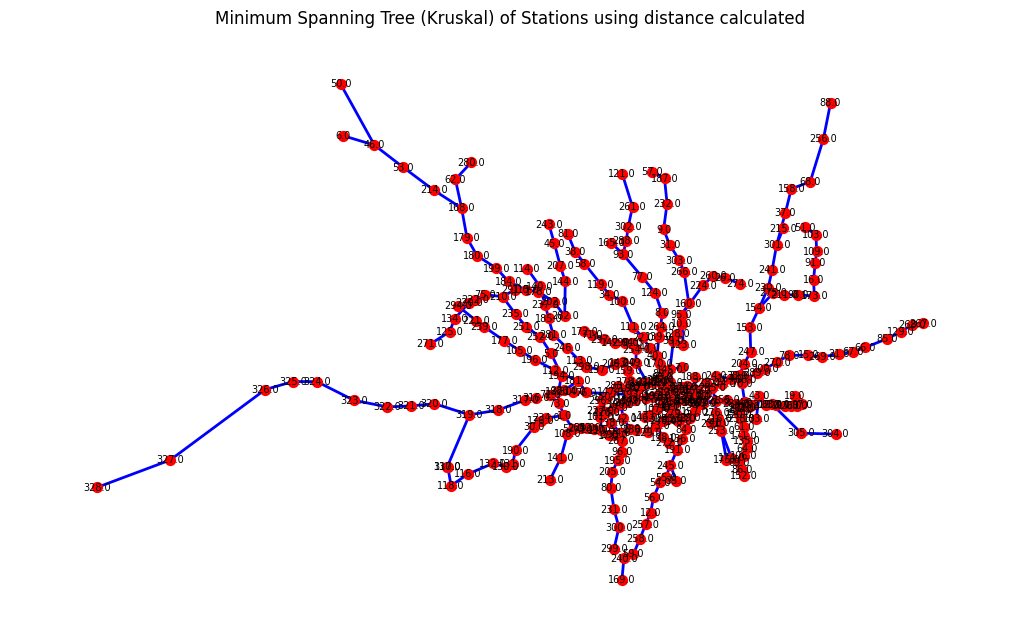

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a dictionary of positions for visualization
pos = {station: (station_coords[station]['longitude'], station_coords[station]['latitude']) for station in station_coords}

plt.figure(figsize=(10, 6))
# Draw the MST(kruskal)
nx.draw(mst, pos, node_size=50, node_color='red', edge_color='blue', width=2, with_labels=True, font_size=7)

plt.title("Minimum Spanning Tree (Kruskal) of Stations using distance calculated")
plt.show()


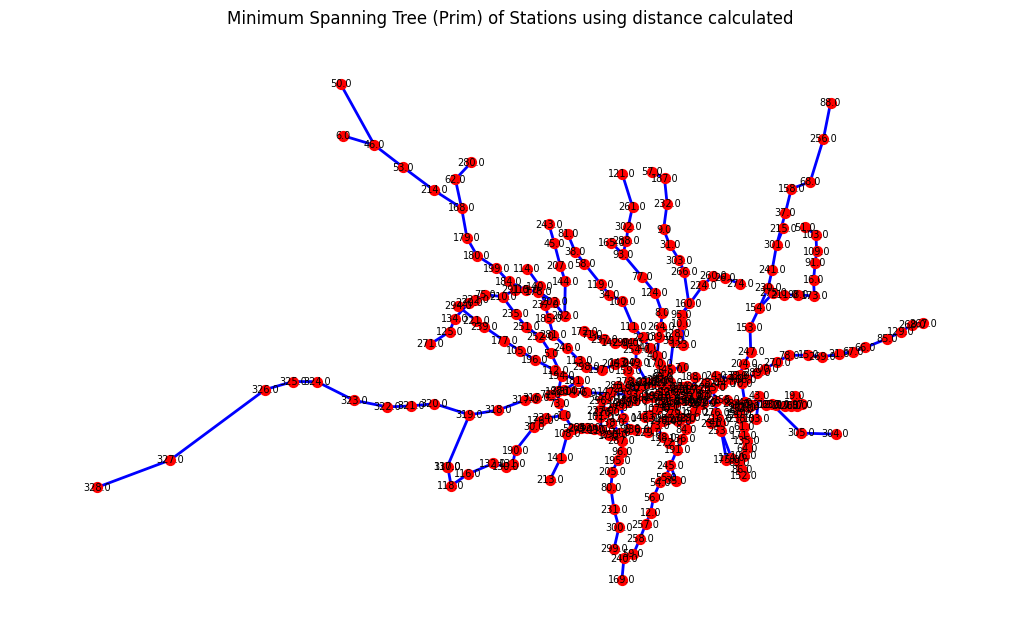

In [22]:
plt.figure(figsize=(10, 6))
# Draw the MST(Prim)
nx.draw(mst2, pos, node_size=50, node_color='red', edge_color='blue', width=2, with_labels=True, font_size=7)

plt.title("Minimum Spanning Tree (Prim) of Stations using distance calculated")
plt.show()

# Q2

In [15]:
G2 = nx.Graph()

for _, row in connections.iterrows():
    station1 = row['station1']
    station2 = row['station2']
    distance = row['distance(miles)']  # Use the provided distance in miles

    if not np.isnan(distance):  # Ensure no missing values
        G2.add_edge(station1, station2, weight=distance)

# Compute the MST
## Method 1: Kruskal
mst3 = nx.minimum_spanning_tree(G2, weight='weight', algorithm='kruskal')
mst_length3 = sum(nx.get_edge_attributes(mst3, 'weight').values())
print(f"Total MST Length (using provided distances): {mst_length3:.2f} miles")

## Method 2: prim
mst4 = nx.minimum_spanning_tree(G2, weight='weight', algorithm='prim')
mst_length4 = sum(nx.get_edge_attributes(mst4, 'weight').values())
print(f"Total MST Length (using provided distances): {mst_length4:.2f} miles")

Total MST Length (using provided distances): 257.44 miles
Total MST Length (using provided distances): 257.44 miles


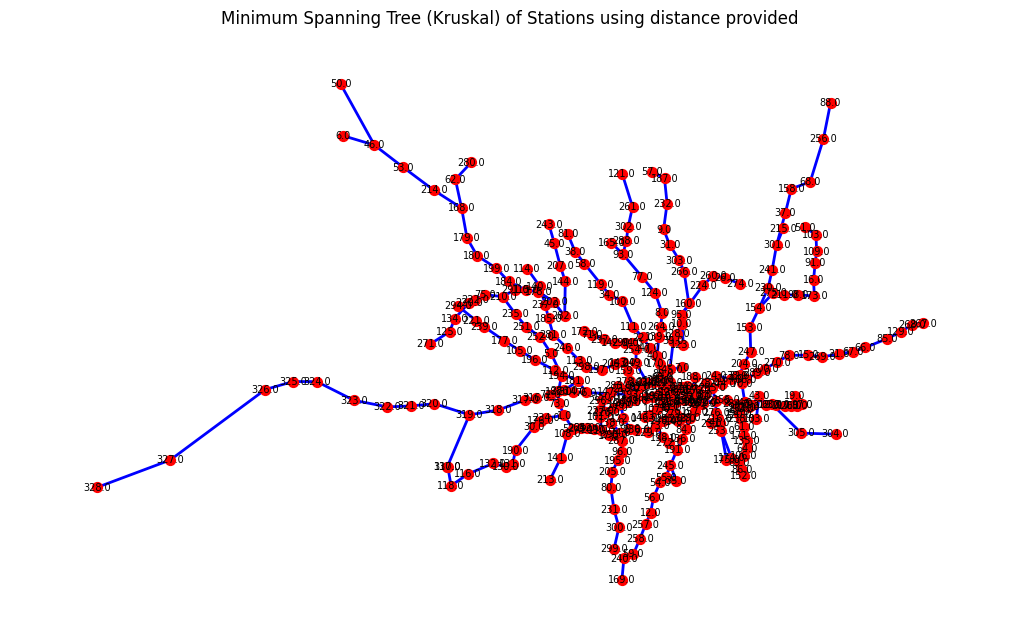

In [23]:
plt.figure(figsize=(10, 6))
# Draw the MST(kruskal)
nx.draw(mst3, pos, node_size=50, node_color='red', edge_color='blue', width=2, with_labels=True, font_size=7)

plt.title("Minimum Spanning Tree (Kruskal) of Stations using distance provided")
plt.show()

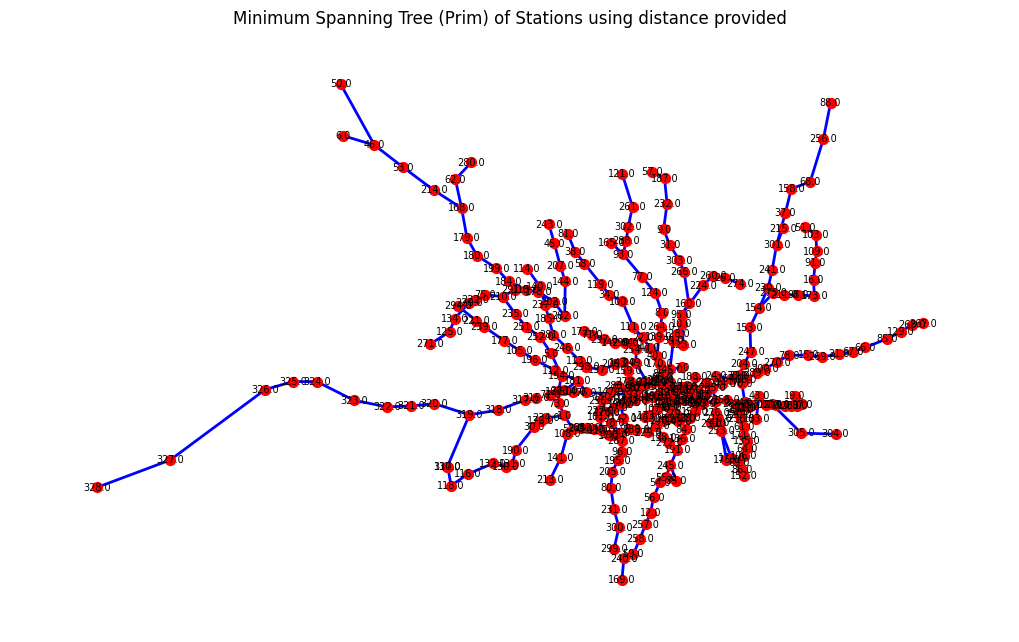

In [24]:
plt.figure(figsize=(10, 6))
# Draw the MST(prim)
nx.draw(mst4, pos, node_size=50, node_color='red', edge_color='blue', width=2, with_labels=True, font_size=7)

plt.title("Minimum Spanning Tree (Prim) of Stations using distance provided")
plt.show()

# Q3

Value-at-Risk (5% level): 244.97 miles


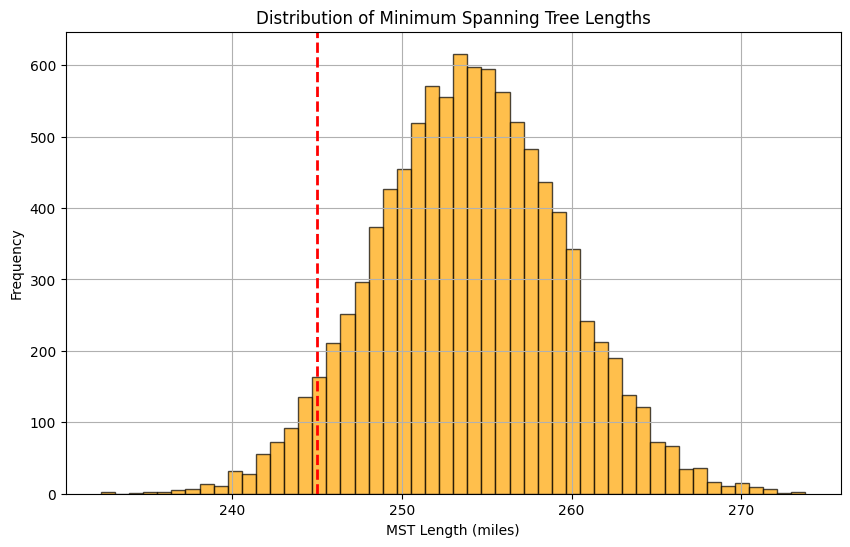

In [ ]:
# Modify the length with Gaussian
def modify_length(true_length):
    noise = np.random.normal(0, 0.3)  # Gaussian noise with mean 0 and std 0.3
    modified = max(true_length * (1 + noise), 0.01 * true_length)  # Adjusted length
    return modified

# Simulate 10,000 experiments
num_experiments = 10000
mst_lengths = []

# Convert connections to a NP array
connection_data = connections[['station1', 'station2', 'distance(miles)']].dropna().to_numpy()

for _ in range(num_experiments):
    # Create a new graph with modified lengths
    G3 = nx.Graph()
    for station1, station2, true_length in connection_data:
        modified_length = modify_length(true_length)
        G3.add_edge(station1, station2, weight=modified_length)

    # Compute MST for the modified graph
    mst = nx.minimum_spanning_tree(G3, weight='weight', algorithm='kruskal')
    mst_length = sum(nx.get_edge_attributes(mst, 'weight').values())
    mst_lengths.append(mst_length)

# 5% VaR
VaR_5 = np.percentile(mst_lengths, 5)
print(f"Value-at-Risk (5% level): {VaR_5:.2f} miles")

# Plot the distribution of MST lengths
plt.figure(figsize=(10, 6))
plt.hist(mst_lengths, bins=50, edgecolor='k', alpha=0.7, color="orange")
plt.axvline(VaR_5, color='red', linestyle='dashed', linewidth=2, label=f'5% VaR: {VaR_5:.2f} miles')
plt.title("Distribution of Minimum Spanning Tree Lengths")
plt.xlabel("MST Length (miles)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Q4

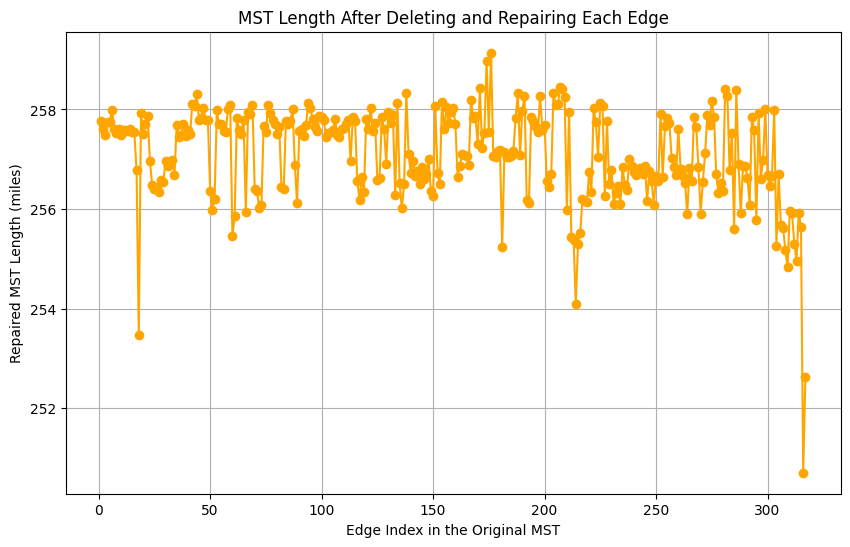

First 10 repaired MST lengths: [257.7615219399068, 257.6084118789682, 257.4897708560489, 257.74444177861034, 257.74596936340714, 257.98293570066494, 257.59894477943317, 257.5201131535752, 257.5992076712135, 257.49106341253474]


In [ ]:
G4 = nx.Graph()
for _, row in connections.iterrows():
    station1 = row['station1']
    station2 = row['station2']
    distance = row['distance(miles)']  # Use the provided distance in miles
    if not np.isnan(distance):  # Ensure no missing values
        G4.add_edge(station1, station2, weight=distance)

# Compute the original MST
original_mst = nx.minimum_spanning_tree(G4, weight='weight', algorithm='kruskal')

# Delete-and-repair analysis
deleted_edge_mst_lengths = []

for edge in original_mst.edges(data=True):
    # Remove the current edge
    G4_temp = G4.copy()
    G4_temp.remove_edge(edge[0], edge[1])

    # Compute the MST for the graph with the edge removed
    repaired_mst = nx.minimum_spanning_tree(G4_temp, weight='weight', algorithm='kruskal')
    repaired_mst_length = sum(nx.get_edge_attributes(repaired_mst, 'weight').values())

    # Store the repaired MST length
    deleted_edge_mst_lengths.append(repaired_mst_length)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(deleted_edge_mst_lengths) + 1), deleted_edge_mst_lengths, marker='o', linestyle='-', color="orange")
plt.title("MST Length After Deleting and Repairing Each Edge")
plt.xlabel("Edge Index in the Original MST")
plt.ylabel("Repaired MST Length (miles)")
plt.grid()
plt.show()

# Output the results for further inspection
print("First 10 repaired MST lengths:", deleted_edge_mst_lengths[:10])
